In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import re
import string
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
from random import randint
%matplotlib inline
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
try:
    from inflection import singularize
except:
    !pip install inflection
    from inflection import singularize

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# Global items
try:
    with open('/content/drive/My Drive/NLP/spell_check_dict.json') as f:
        spell_check_dict = json.load(f)
    spelling_dictionary_imported = True
except:
    spell_check_dict = dict()
    spelling_dictionary_imported = False
    
randomSeed = 5

# create a metric as RMSE is not provided in the scoring parameter in cross-validation
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error = np.sqrt(mean_squared_error(ground_truth, predictions))
    return fmean_squared_error
RMSE = make_scorer(fmean_squared_error, greater_is_better=False)

In [0]:
class RelevanceScorePrediction:
    def __init__(self, settings):
        self.path_to_files = settings['path_to_files']        
        self.train_path = self.path_to_files + "/train.csv"
        self.test_path = self.path_to_files + "/test.csv"
        self.product_descriptions_path = self.path_to_files + "/product_descriptions.csv"
        self.attributes_path = self.path_to_files + "/attributes.csv"
        
        self.df_train = pd.read_csv(self.train_path, encoding='ISO-8859-1', header=0)
        self.df_test = pd.read_csv(self.test_path, encoding='ISO-8859-1', header=0)
        self.df_product_desc = pd.read_csv(self.product_descriptions_path, header=0)
        self.df_product_attr = pd.read_csv(self.attributes_path, header=0)

    # Functions that reads the dataframes  
    def reads_and_merges(self):
        print('The shape of train is:', self.df_train.shape)
        print('The info of train is: ')
        print(self.df_train.info())
        self.len_train = self.df_train.shape[0]
        print('The len_train is: ')
        print(self.len_train)
        
        print('\n The shape of test is:', self.df_test.shape)
        print('The info of test is: ')
        print(self.df_test.info())
        
        print('\n The shape of product description is: ', self.df_product_desc.shape)
        print('The info of product description is: ')
        print(self.df_product_desc.info())

        print('\n The shape of product attributes is: \n', self.df_product_attr.shape)
        print('The null values of product attributes before drop are: \n', self.df_product_attr.isnull().sum())

        self.df_product_attr = self.df_product_attr.dropna(how="all")
        self.df_product_attr["product_uid"] = self.df_product_attr["product_uid"].astype("int64")
        print('The null values of product attributes after drop are: \n', self.df_product_attr.isnull().sum())
        
        # merge train with test
        self.df_train_test = pd.concat([self.df_train, self.df_test], axis=0, ignore_index=True)
        print('The shape of train-test dataframe is: ', self.df_train_test.shape)
        
        # For attributes table, we are only interested in brand names which could be included in search queries.
        self.df_product_brand = self.df_product_attr[self.df_product_attr.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "brand"})
        print('The shape of product_brand is: ', self.df_product_brand.shape)
        
        # merge train_test with product attributes
        self.df_train_test_brands = pd.merge(self.df_train_test, self.df_product_brand, how='left', on='product_uid')
        print('The shape of train_test_brands is: ', self.df_train_test_brands.shape)
        print('The info of train_test_brands is: ')
        print(self.df_train_test_brands.info())
        self.df_train_test_brands["brand"] = self.df_train_test_brands["brand"].astype(str)
        self.df_train_test_brands.fillna("unknown", inplace=True)
        print('The info of train_test_brands after filling null values is: ')
        print(self.df_train_test_brands.info())
        
        return self.df_train, self.df_test, self.df_product_desc, self.df_product_attr, self.df_train_test, self.df_train_test_brands

    def preprocessing(self):
        self.df_train, self.df_test, self.df_product_desc, self.df_product_attr, self.df_train_test, self.df_train_test_brands = self.reads_and_merges()
        
        # Function to perform simole regex
        def simple_regex(text, regex1, sub1, regex2, sub2, regex3, sub3):
            text = re.sub(regex1, sub1, text) # add space after . if it doesn't exist.also avoid add space after the last .
            text = re.sub(regex2, sub2, text) # do this also for ;
            text = re.sub(regex3, sub3, text) # add space Capital words that are in the form textTex
            return text

        # Perfom simple regex
        print('Perform text corrections with regex')
        start_regex = time.time()
        regex1 = r"\.(?!\s)(?!$)"
        sub1 = ". "
        regex2 = r"\;(?!\s)(?!$)"
        sub2 = "; "
        regex3 = r"([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))"
        sub3 = r"\1 "
        self.df_train_test_brands['search_term'] = self.df_train_test_brands['search_term'].map(lambda x: simple_regex(x, regex1, sub1, regex2, sub2, regex3, sub3))
        print("product_title...")
        self.df_train_test_brands['product_title'] = self.df_train_test_brands['product_title'].map(lambda x: simple_regex(x, regex1, sub1, regex2, sub2, regex3, sub3))
        print("brand...")
        self.df_train_test_brands['brand'] = self.df_train_test_brands['brand'].map(lambda x: simple_regex(x, regex1, sub1, regex2, sub2, regex3, sub3))
        print("product_description...")
        print('initial: \n', self.df_product_desc['product_description'][1])
        self.df_product_desc['product_description'] = self.df_product_desc['product_description'].map(lambda x: simple_regex(x, regex1, sub1, regex2, sub2, regex3, sub3))
        print('after regex: \n', self.df_product_desc['product_description'][1])
        end_regex = time.time()
        print("Simple regex finished in ", (end_regex - start_regex), "seconds")

        # Function to correct measurement units
        def measurement_unit_correction(text):
            """
            This function preprocess a string. Corrects measurement units.
            Input: A string
            Output: A string with corrected measurements
            Example: text = measurement_unit_correction(text)
            """
            if isinstance(text, str):

                metric = text.lower()

                metric = metric.replace("centimeters"," cm.")    

                metric = metric.replace("millimeters"," mm.")

                metric = metric.replace("'"," in. ") 
                metric = metric.replace("inches"," in. ") 
                metric = metric.replace("inch"," in. ")
                metric = metric.replace("''"," ft. ") 
                metric = metric.replace("feet"," ft. ") 
                metric = metric.replace("foot"," ft. ") 
                metric = metric.replace("sq ft"," sq.ft. ") 
                metric = metric.replace("sqft "," sq.ft. ")
                metric = metric.replace("sq. ft"," sq.ft. ") 
                metric = metric.replace("sq ft."," sq.ft. ") 
                metric = metric.replace("sq feet"," sq.ft. ") 
                metric = metric.replace("square feet"," sq.ft. ") 

                metric = metric.replace("pounds"," lb. ")
                metric = metric.replace("pound"," lb. ") 
                metric = metric.replace("lbs "," lb. ") 
                metric = metric.replace("lbs."," lb. ") 

                metric = metric.replace(" x "," xby ")
                metric = metric.replace("*"," xby ")
                metric = metric.replace("by"," xby ")
                metric = metric.replace("x0"," xby 0 ")
                metric = metric.replace("x1"," xby 1 ")
                metric = metric.replace("x2"," xby 2 ")
                metric = metric.replace("x3"," xby 3 ")
                metric = metric.replace("x4"," xby 4 ")
                metric = metric.replace("x5"," xby 5 ")
                metric = metric.replace("x6"," xby 6 ")
                metric = metric.replace("x7"," xby 7 ")
                metric = metric.replace("x8"," xby 8 ")
                metric = metric.replace("x9"," xby 9 ")
                metric = metric.replace("0x"," 0 xby ")
                metric = metric.replace("1x"," 1 xby ")
                metric = metric.replace("2x"," 2 xby ")
                metric = metric.replace("3x"," 3 xby ")
                metric = metric.replace("4x"," 4 xby ")
                metric = metric.replace("5x"," 5 xby ")
                metric = metric.replace("6x"," 6 xby ")
                metric = metric.replace("7x"," 7 xby ")
                metric = metric.replace("8x"," 8 xby ")
                metric = metric.replace("9x"," 9 xby ")
            
                metric = metric.replace("gallon"," gal. ")
                metric = metric.replace("gallons"," gal. ") 

                metric = metric.replace("ounces"," oz. ")
                metric = metric.replace("ounce"," oz. ")
                
                metric = metric.replace("°"," deg. ")
                metric = metric.replace("degrees"," deg. ")
                metric = metric.replace("degree"," deg. ")
                
                metric = metric.replace("volts"," volt. ")

                metric = metric.replace("watts"," watt. ")
                metric = metric.replace("watt"," watt. ")

                metric = metric.replace("ampere"," amp. ")
                metric = metric.replace("amps"," amp. ")

                return metric

        print('Measurement unit correction...')
        start_units = time.time()
        print('search term...')
        self.df_train_test_brands['search_term'] = self.df_train_test_brands['search_term'].map(lambda x: measurement_unit_correction(x))
        print("product_title...")
        self.df_train_test_brands['product_title'] = self.df_train_test_brands['product_title'].map(lambda x: measurement_unit_correction(x))
        print("brand...")
        self.df_train_test_brands['brand'] = self.df_train_test_brands['brand'].map(lambda x: measurement_unit_correction(x))
        print("product_description...")
        self.df_product_desc['product_description'] = self.df_product_desc['product_description'].map(lambda x: measurement_unit_correction(x))
        end_units = time.time()
        print("Measurement unit correction finished in ", (end_units - start_units), "seconds")

        # Function to remove stopwords from a string
        def stopwords_removal(text, cachedStopWords):
            """
            This function preprocess a string. Removes stopwords.
            Input: A string
            Output: A string cleaned from stop_words
            Example: text = stopwords_removal(text)
            """
            if not isinstance(text, str):
                return text

            words = nltk.word_tokenize(text.lower())
            no_stopwords = [word for word in words if word not in cachedStopWords]
            return ' '.join(no_stopwords)
    
        # stopwords removal
        print("Removing stopwords...")
        start_stopwords = time.time()
        cachedStopWords = stopwords.words('english')
        print('The stopwords are: ', cachedStopWords) # to see the english stopwords
        print("search_term...")
        self.df_train_test_brands['search_term'] = self.df_train_test_brands['search_term'].map(lambda x: stopwords_removal(x,cachedStopWords))
        print("product_title...")
        self.df_train_test_brands['product_title'] = self.df_train_test_brands['product_title'].map(lambda x: stopwords_removal(x, cachedStopWords))
        print("brand...")
        self.df_train_test_brands['brand'] = self.df_train_test_brands['brand'].map(lambda x: stopwords_removal(x, cachedStopWords))
        print("product_description...")
        self.df_product_desc['product_description'] = self.df_product_desc['product_description'].map(lambda x: stopwords_removal(x, cachedStopWords))
        print(self.df_product_desc['product_description'][1])
        end_stopwords = time.time()
        print("Stopwords removal finished in ", (end_stopwords - start_stopwords), "seconds")
        print("----------------------------------------------------")

        # Function to remove punctuations from a string
        def punctuations_removal(text, translate_table_punctuations):
            """
            This function preprocess a string. Removes punctuations.
            Input: A string
            Output: A string cleaned from punctuations
            Example: text = punctuation_removal(text)
            look also this: https://stackoverflow.com/questions/43935592/add-space-after-full-stops
            """
            if not isinstance(text, str):
                return text
            return text.translate(translate_table_punctuations)

        # punctuation removal
        print("Removing punctuations...")
        start_punc = time.time()
        punctuations = string.punctuation
        print('The punctuations are: ', punctuations) # to see the punctuations
        translate_table_punctuations = str.maketrans("","",punctuations)
        print("search_term...")
        self.df_train_test_brands['search_term'] = self.df_train_test_brands['search_term'].map(lambda x: punctuations_removal(x, translate_table_punctuations))
        print("product_title...")
        self.df_train_test_brands['product_title'] = self.df_train_test_brands['product_title'].map(lambda x: punctuations_removal(x, translate_table_punctuations))
        print("brand...")
        self.df_train_test_brands['brand'] = self.df_train_test_brands['brand'].map(lambda x: punctuations_removal(x, translate_table_punctuations))
        print("product_description...")
        self.df_product_desc['product_description'] = self.df_product_desc['product_description'].map(lambda x: punctuations_removal(x, translate_table_punctuations))
        print(self.df_product_desc['product_description'][1])
        end_punc = time.time()
        print("Punctuation removal finished in ", (end_punc - start_punc), "seconds")
        print("----------------------------------------------------")

        
        # Function to correct spelling errors
        def spell_check(text):
            if spelling_dictionary_imported:
                return spell_check_dict[text]
            
            def P(word, N=sum(WORDS.values())): 
                "Probability of `word`."
                return WORDS[word] / N

            def correction(word): 
                "Most probable spelling correction for word."
                return max(candidates(word), key=P)

            def candidates(word): 
                "Generate possible spelling corrections for word."
                return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

            def known(words): 
                "The subset of `words` that appear in the dictionary of WORDS."
                return set(w for w in words if w in WORDS)

            def edits1(word):
                "All edits that are one edit away from `word`."
                letters    = 'abcdefghijklmnopqrstuvwxyz'
                splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
                deletes    = [L + R[1:]               for L, R in splits if R]
                transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
                replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
                inserts    = [L + c + R               for L, R in splits for c in letters]
                return set(deletes + transposes + replaces + inserts)

            def edits2(word): 
                "All edits that are two edits away from `word`."
                return (e2 for e1 in edits1(word) for e2 in edits1(e1))

            lower_case_input = text.lower()
            tokens = word_tokenize(lower_case_input)
            corrected = [correction(token) for token in tokens]
            spell_check_dict[lower_case_input] = ' '.join(corrected)
            return ' '.join(corrected)

        # Spell Correction
        if not spelling_dictionary_imported:
            print("Creating vocabulary for spell correction...")
            wordsArr = []
            vocabulary_columns = [self.df_train_test_brands["product_title"], self.df_product_desc["product_description"], self.df_train_test_brands["brand"]]
            for column in vocabulary_columns:
                for entry in column:
                    words = word_tokenize(entry.lower())
                    for word in words:
                        wordsArr.append(word)

            WORDS = Counter(wordsArr)
            print("Top 5 most common words found in description, title and brand: ", WORDS.most_common(5))
        
        print("Spell correcting...")
        start_spell = time.time()
        self.df_train_test_brands['search_term'] = self.df_train_test_brands['search_term'].map(lambda x: spell_check(x))
        end_spell = time.time()
        print("Spell correction finished in ", (end_spell - start_spell), "seconds")

        # Store the dictionary to file to use as static from now on
        if not spelling_dictionary_imported:
            with open('/content/drive/My Drive/spell_check_dict.json', 'w') as j:
                j.write(json.dumps(spell_check_dict))
        print("----------------------------------------------------")


        def singulairze_text(text):
            return ' '.join([singularize(word) for word in text.split()])

        print("Singularizing...")
        start_singularize = time.time()
        print("search_term...")
        self.df_train_test_brands['search_term'] = self.df_train_test_brands['search_term'].map(lambda x: singulairze_text(x))
        print("product_description...")
        self.df_product_desc['product_description'] = self.df_product_desc['product_description'].map(lambda x: singulairze_text(x))
        print(self.df_product_desc['product_description'][1])
        end_singularize = time.time()
        print("Singularizing finished in ", (end_singularize - start_singularize), "seconds")

        # Function to perform stemming
        def simple_stemming(text, snowball_stemmer):
            if not isinstance(text, str):
                return text
            tokens = word_tokenize(text.lower())
            stemmed = [snowball_stemmer.stem(word) for word in tokens]
            return ' '.join(stemmed)

        # Perform simple stemming
        print("Performing simple stemming...")
        start_stem = time.time()
        snowball_stemmer = SnowballStemmer('english', ignore_stopwords=True)
        print("search_term...")
        self.df_train_test_brands['search_term'] = self.df_train_test_brands['search_term'].map(lambda x: simple_stemming(x, snowball_stemmer))
        print("product_title...")
        self.df_train_test_brands['product_title'] = self.df_train_test_brands['product_title'].map(lambda x: simple_stemming(x, snowball_stemmer))
        print("brand...")
        self.df_train_test_brands['brand'] = self.df_train_test_brands['brand'].map(lambda x: simple_stemming(x, snowball_stemmer))
        print("product_description...")
        self.df_product_desc['product_description'] = self.df_product_desc['product_description'].map(lambda x: simple_stemming(x, snowball_stemmer))
        print(self.df_product_desc['product_description'][1])
        end_stem = time.time()
        print("Simple stemming finished in ", (end_stem - start_stem), "seconds")
        
        self.df_merged = self.df_train_test_brands.merge(self.df_product_desc, how='left', on='product_uid')
        print('\n The shape of train_test with products_description is: ', self.df_merged.shape)
        print(self.df_merged.info())
        return self.df_merged
    
    # Function to constract new features
    def feature_engineering(self):
        self.df_merged = self.preprocessing()
        
        # Add new columns with the length of the column
        print("creating len columns...")
        start_length = time.time()
        self.df_merged['len_of_query'] = self.df_merged['search_term'].map(lambda x: len(x.split())).astype(np.int64)
        self.df_merged['len_of_title'] = self.df_merged['product_title'].map(lambda x:len(x.split())).astype(np.int64)
        self.df_merged['len_of_description'] = self.df_merged['product_description'].map(lambda x:len(x.split())).astype(np.int64)
        self.df_merged['len_of_brand'] = self.df_merged['brand'].apply(lambda x:len(x.split())).astype(np.int64)
        end_length = time.time()
        print("Length calculation finished in ", (end_length - start_length), "seconds")

        # Add a product_all_info column summarizing the attributes of products seperating by TAB
        print("creating combination of columns...")
        self.df_merged['product_all_information'] = self.df_merged['search_term'] + "\t" + self.df_merged['product_title'] + "\t" + self.df_merged['product_description']
        self.df_merged['brand_helper'] = self.df_merged['search_term'] + "\t" + self.df_merged['brand'] + "\t" + self.df_merged['product_title']

        # Function to find number of common words.
        def num_common_words(str_1, str_2):
            if not isinstance(str_1, str) or not isinstance(str_2, str):
                return 0
            return sum(int(str_2.find(word)>=0) for word in str_1.split())

        # Add new columns with common words of the search term with product title and the search term with description
        print("creating common_words title/description...")
        start_common_words = time.time()
        self.df_merged['common_words_in_title'] = self.df_merged['product_all_information'].map(lambda x: num_common_words(x.split('\t')[0], x.split('\t')[1]))
        self.df_merged['common_words_in_description'] = self.df_merged['product_all_information'].map(lambda x: num_common_words(x.split('\t')[0], x.split('\t')[2]))
        self.df_merged['common_words_in_brand'] = self.df_merged['brand_helper'].map(lambda x: num_common_words(x.split('\t')[0], x.split('\t')[1]))
        end_common_words = time.time()
        print("Common words calculation finished in ", (end_common_words - start_common_words), "seconds")

        # Function to find common phrase
        def num_whole_word(str_1, str_2, i):
            if not isinstance(str_1, str) or not isinstance(str_2, str):
                return 0

            str_1, str_2 = str_1.strip(), str_2.strip()
            count = 0
            while i < len(str_2):
                i = str_2.find(str_1, i)
                if i == -1:
                    return count
                else:
                    count += 1
                    i += len(str_1)
            return count

        # Add new columns with number of times the entire search term appears in product title and number of times the entire search term appears in product description.
        # print("creating query_in_X columns...")
        # start_whole_word = time.time()
        # print("query_in_title...")
        # self.df_merged['query_in_title'] = self.df_merged['product_all_information'].map(lambda x: num_whole_word(x.split('\t')[0], x.split('\t')[1],0))
        # print("query_in_description...")
        # self.df_merged['query_in_description'] = self.df_merged['product_all_information'].map(lambda x: num_whole_word(x.split('\t')[0], x.split('\t')[2],0))
        # print("query_in_brand...")
        # self.df_merged['query_in_brand'] = self.df_merged['brand_helper'].map(lambda x: num_whole_word(x.split('\t')[0], x.split('\t')[1],0))
        # end_whole_word = time.time()
        # print("Whole word calculation finished in ", (end_whole_word - start_whole_word), "seconds")

        # Add new columns with the ratio of common words in title with respect to query and ratio of common words in description with respect to query
        print("creating ratio columns...")
        start_ratio = time.time()
        self.df_merged['ratio_title'] = self.df_merged['common_words_in_title'] / self.df_merged['len_of_query']
        self.df_merged['ratio_description'] = self.df_merged['common_words_in_description'] / self.df_merged['len_of_query']
        # self.df_merged['ratio_brand'] = self.df_merged['query_in_brand'] / self.df_merged['len_of_brand']

        self.df_merged['query_title_len_prop'] = self.df_merged['len_of_title'] / self.df_merged['len_of_query']
        self.df_merged['query_desc_len_prop'] = self.df_merged['len_of_description'] / self.df_merged['len_of_query']
        self.df_merged = self.df_merged.replace([np.inf, -np.inf], np.nan)
        print(self.df_merged.info())
        self.df_merged['ratio_title'].fillna(0.0, inplace = True)
        self.df_merged['ratio_description'].fillna(0.0, inplace = True)
        self.df_merged['query_title_len_prop'].fillna(0.0, inplace = True)
        self.df_merged['query_desc_len_prop'].fillna(0.0, inplace = True)
        print(self.df_merged.info())
        end_ratio = time.time()
        print("Ratio calculation finished in ", (end_ratio - start_ratio), "seconds")
        
      # Function to compute jaccard similarity
        def jaccard_sim(str_1, str_2):
            if not isinstance(str_1, str) or not isinstance(str_2, str):
                return 0
            set_1 = set(str_1.split())
            set_2 = set(str_2.split())
            if len(set_1.union(set_2)) == 0:
              return 0
            return len(set_1.intersection(set_2)) / (float(len(set_1.union(set_2))))

        # Add new columns with jaccard similarity of search term and product title and search term and product description
        print("creating jacard columns ....")
        start_jaccard = time.time()
        self.df_merged['jaccard_search_and_title'] = self.df_merged['product_all_information'].map(lambda x: jaccard_sim(x.split('\t')[0], x.split('\t')[1])).round(3)
        self.df_merged['jaccard_search_and_description'] = self.df_merged['product_all_information'].map(lambda x: jaccard_sim(x.split('\t')[0], x.split('\t')[2])).round(3)
        self.df_merged['jaccard_search_and_brand'] = self.df_merged['brand_helper'].map(lambda x: jaccard_sim(x.split('\t')[0], x.split('\t')[1])).round(3)
        end_jaccard = time.time()
        print("Jaccard calculation finished in ", (end_jaccard - start_jaccard), "seconds")

        # Function to compute the number of common ngrams
        def common_ngrams(str_1, str_2, n):
            bigrams_1 = ngrams(str_1.lower().split(), n)
            bigrams_2 = ngrams(str_2.lower().split(), n)
            common = []
            for grams_1 in bigrams_1:
                if grams_1 in bigrams_2:
                    common.append(grams_1)
            if not common:
              return 0
            else:
              return len(common)

        # Add new columns with number of common ngrams
        print("creating ngrams columns ....")
        start_ngrams = time.time()
        self.df_merged['ngrams_search_and_title'] = self.df_merged['product_all_information'].map(lambda x: common_ngrams(x.split('\t')[0], x.split('\t')[1], 2))
        self.df_merged['ngrams_search_and_description'] = self.df_merged['product_all_information'].map(lambda x: common_ngrams(x.split('\t')[0], x.split('\t')[2], 2))
        self.df_merged['ngrams_search_and_brand'] = self.df_merged['brand_helper'].map(lambda x: common_ngrams(x.split('\t')[0], x.split('\t')[2], 2))
        end_ngrams = time.time()
        print("ngrams calculation finished in ", (end_ngrams - start_ngrams), "seconds")

        return self.df_merged
    

    def train_and_predict(self, compare_many=False, grid=False, xgb=True):
        self.df_merged = self.feature_engineering()
        print(self.df_merged.head(2))
        # Drop the unecessary columns
        df = self.df_merged.drop(columns=['search_term','product_title','product_description','product_all_information','product_uid','brand','brand_helper'],axis=1)
        print(df.info())

        df_train = df.iloc[:self.len_train]
        # df_train.reset_index(drop=True, inplace=True)
        print(df_train.shape)
        print(df_train.head(5))

        df_test = df.iloc[self.len_train:]
        # df_test.reset_index(drop=True, inplace=True)
        print(df_test.shape)
        id_test = df_test['id'] # keep this for exporting to csv
        print(id_test.shape)
        print(df_test.head(5))

        X = df_train.drop(columns=['relevance', 'id']) # drop label and id
        y = df_train['relevance']

        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            train_size=0.7,
                                                            test_size=0.3,
                                                            random_state=randomSeed,
                                                            )
        print('X_train shape ', X_train.shape)
        print('X test shape ', X_test.shape)

        if compare_many:
            dict_regressors = {"Linear": LinearRegression(),
                              "Ridge": Ridge(),
                              "SVR": SVR(),
                              "RF": RandomForestRegressor(),
                              "GBR": GradientBoostingRegressor(),
                              "XGBoost": XGBRegressor(),
                              }

            for name, model in dict_regressors.items():
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                mse = mean_squared_error(y_pred, y_test)
                rmse = np.sqrt(mse)
                print(name, ' RMSE is: %.4f' % rmse)

        elif grid:
            # gb = GradientBoostingRegressor(random_state=randomSeed)

            # # Set the parameter values for GridSearch
            # param_grid = {'n_estimators': [100, 200, 400, 600],
            #               'min_samples_leaf':[3, 5, 7],
            #               'max_depth': [2, 4, 6]
            #              }
            # model = GridSearchCV(estimator= gb,
            #                     param_grid= param_grid,
            #                     n_jobs= -1,
            #                     cv= 10, 
            #                     verbose= 20,
            #                     scoring= RMSE)

            # model.fit(X_train, y_train)
            # y_pred = model.predict(X_test)
            # print("GB: Best parameters found by grid search:", model.best_params_)
            # print("Gradient Boosting's best CV score: %.4f" % model.best_score_)

            # print('-----------------------------------------------------------')

            xgboost = XGBRegressor(random_state=randomSeed)
            param_grid = {'min_child_weight': [1, 3, 5, 7],
                          'max_depth': 6,
                          'subsample ': 0.7,
                          'colsample_bytree ': [2,4,6]
                         }
            model = GridSearchCV(estimator= xgboost,
                                param_grid= param_grid,
                                n_jobs= -1,
                                cv= 3, 
                                verbose= 20,
                                scoring= RMSE)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            print("XGB: Best parameters found by grid search:", model.best_params_)
            print("XGB's best CV score: %.4f" % model.best_score_)

            feat_importances = pd.Series(model.feature_importances_, index=df.columns)
            feat_importances = feat_importances.nlargest(19)
            feat_importances.plot(kind='barh' , figsize=(10,10)) 

            # XGB: Best parameters found by grid search: {'colsample_bytree ': 0.75, 'max_depth': 6, 'min_child_weight': 6, 'subsample ': 0.75}
            # XGB's best CV score: -0.4799

            # XGB: Best parameters found by grid search: {'colsample_bytree ': 6, 'max_depth': 6, 'min_child_weight': 3, 'subsample ': 0.7}
            # XGB's best CV score: -0.4807
            
            # predictions = pd.DataFrame({"id": id_test,
            #                     "relevance": y_pred})
            # predictions.to_csv('predictions_rf.csv', index=False)

        elif xgb:
            xgbr = XGBRegressor(random_state=randomSeed,
                                learning_rate=0.3, 
                                n_estimators=1000,
                                min_child_weight=6,
                                subsample=0.75,
                                max_depth=6,
                                colsample_bytree=0.75)
            
            xgbr.fit(X_train, y_train)
            y_pred = xgbr.predict(X_test)

            mse = mean_squared_error(y_pred, y_test)
            rmse = np.sqrt(mse)
            print('RMSE is: %.4f' % rmse)

            x_ax = range(len(y_test))
            plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
            plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
            plt.legend()
            plt.show()

            feat_importances = pd.Series(xgbr.feature_importances_, index=X.columns)
            feat_importances = feat_importances.nlargest(19)
            feat_importances.plot(kind='barh', figsize=(10,10)) 

In [0]:
settings = {
    'path_to_files': '/content/drive/My Drive/NLP', # path_to_files = "/content/drive/My Drive/NLP"
}

In [0]:
rsp = RelevanceScorePrediction(settings)

The shape of train is: (74067, 5)
The info of train is: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             74067 non-null  int64  
 1   product_uid    74067 non-null  int64  
 2   product_title  74067 non-null  object 
 3   search_term    74067 non-null  object 
 4   relevance      74067 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB
None
The len_train is: 
74067

 The shape of test is: (166693, 4)
The info of test is: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             166693 non-null  int64 
 1   product_uid    166693 non-null  int64 
 2   product_title  166693 non-null  object
 3   search_term    166693 non-null  object
dty

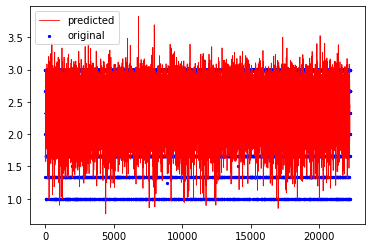

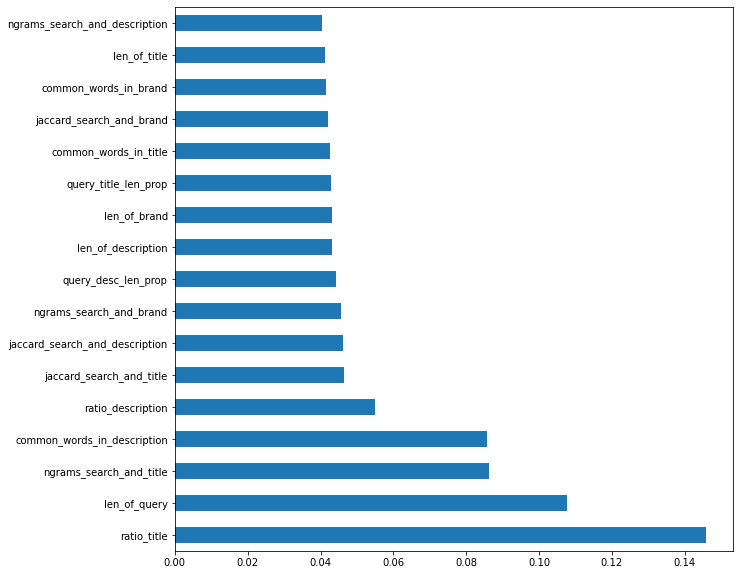

In [7]:
# rsp.train_and_predict(compare_many=True)
# rsp.train_and_predict(grid=True)
rsp.train_and_predict(xgb=True)

In [8]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


In [0]:
# rf = RandomForestRegressor(random_state=randomSeed)

# # Set the parameter values for GridSearch
# param_grid = {'max_samples': [0.1, 0.2, 0.4],
#               'n_estimators': [100, 200, 300],
#               'min_samples_split': [2, 4, 6]
#              }

# model = GridSearchCV(estimator= rf,
#                     param_grid= param_grid,
#                     n_jobs= -1,
#                     cv= 10, 
#                     verbose= 20,
#                     scoring= RMSE
#                     )

# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("RF: Best parameters found by grid search:", model.best_params_)
# print("Random Forest's best CV score: %.4f" % model.best_score_)

# # Gradient Boosting regressor. It has not been used in conjunction to Bagging regressor
# gb = GradientBoostingRegressor(random_state=randomSeed)
# gb.fit(X_train, y_train)
# y_pred = gb.predict(X_test)

# model = GridSearchCV(estimator= clf,
#                                 param_grid= param_grid,
#                                 n_jobs= -1,
#                                 cv= 2, 
#                                 verbose= 20,
#                                 scoring= RMSE)
# model.fit(X_train, y_train)
# print("RF: Best parameters found by grid search:", model.best_params_)
# print("Random Forest's best CV score: %.4f" % model.best_score_)

3. Bagging Regressor to improve Random Forest

In [0]:
# clf = BaggingRegressor(base_estimator= rf, random_state=randomSeed)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

# # Set the parameter values for GridSearch
# param_grid = {'max_samples': [0.1, 0.2],
#               'n_estimators': [10, 100, 150],
#               'min_samples_split': [2, 4, 6]
#              }

# model = GridSearchCV(
#     estimator= rf,
#     param_grid= param_grid,
#     n_jobs= -1,
#     cv= 10, 
#     verbose= 20,
#     scoring= RMSE
# )

# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("RF: Best parameters found by grid search:", model.best_params_)
# print("Random Forest's best CV score: %.4f" % model.best_score_)

In [0]:
# descr = pd.read_csv('/content/drive/My Drive/Colab Notebooks/product_descriptions.csv', header=0)
# pd.options.display.max_rows = 100
# pd.set_option('max_colwidth', 9000)
# print(descr[descr['product_description'].str.contains("oz")]['product_description'])

# # descr['product_description'].apply(lambda x: ngrams(x.lower().split(), 3)